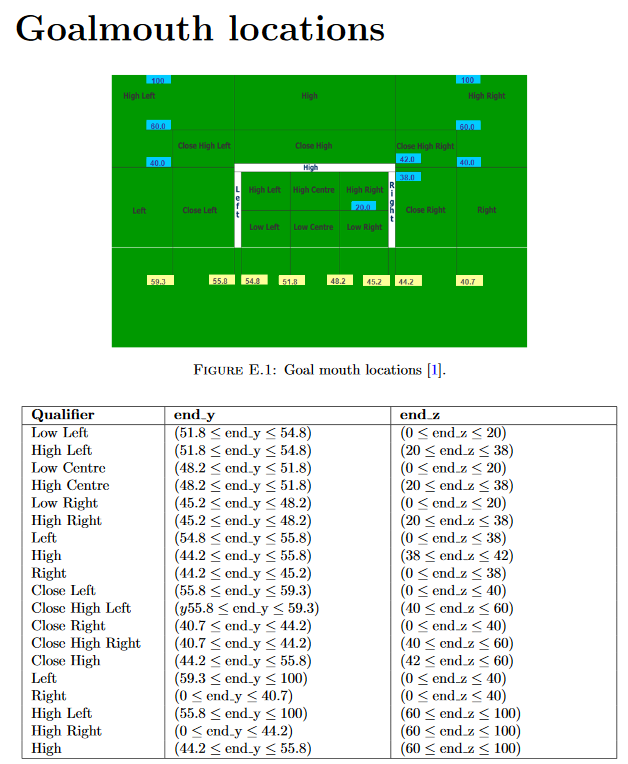
From https://pure.tue.nl/ws/portalfiles/portal/47028874/797423-1.pdf

Data files available at https://drive.google.com/drive/folders/1LhW3wcG5uoAAHcgPHRcJYmIQaMY9GlRI?usp=sharing

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from data_viz_helpers import *

In [26]:
def valid_shot(event):
    """
    Function to determine if an Opta event is a valid shot. For the 
    purpose of this psxG model, a valid shot is a shot on target that 
    is not blocked.
    """
    
    if event['type']['displayName']=='SavedShot':
        # Ignore blocked shots
        for qual in event['qualifiers']:
            if qual['type']['displayName'] == 'Blocked':
                return False
        return True
    
    elif event['type']['displayName']=='Goal':
        return True
    
    elif event['type']['displayName']=='MissedShots':
        z, y = event['goalMouthZ'], event['goalMouthY']
        return (z<=38) and (y>=45.2) and (y<=54.8)
    
    elif event['type']['displayName']=='ShotOnPost':
        z, y = event['goalMouthZ'], event['goalMouthY']
        return (z<=38) and (y>=45.2) and (y<=54.8)

# Load data and parse out valid shots on target

In [27]:
df = pd.DataFrame(columns=['z', 'y', 'goal'])
shots = list()

for filename in [
        'Bundesliga_2010_match_data.json', 
        'EPL_2018_match_data.json', 
        'EPL_2019_match_data.json', 
        'EPL_2020_match_data.json',
        'EPL_2021_match_data.json',
        'La Liga_2021_match_data.json',
        'Serie A_2011_match_data.json'
    ]:
    # Read data from JSON file
    with open(filename, 'r') as f:
        data = json.loads(f.read())
    
    # Parse out shots on target
    for item in data.items():
        for event in item[1]['matchCentreData']['events']:
            try:
                valid = valid_shot(event)
            except:
                continue
            if valid:
                # Save shot data for valid shots
                shots.append(event)
                new_row = pd.Series(dtype='float')
                new_row['z'] = event['goalMouthZ']
                new_row['y'] = event['goalMouthY']
                new_row['goal'] = int(event['type']['displayName']=='Goal')
                df = df.append(new_row, ignore_index=True)
    print('Loaded {}, {} valid shots found so far'.format(filename, df.shape[0]))

Loaded Bundesliga_2010_match_data.json, 2835 valid shots found so far
Loaded EPL_2018_match_data.json, 5973 valid shots found so far
Loaded EPL_2019_match_data.json, 9248 valid shots found so far
Loaded EPL_2020_match_data.json, 12486 valid shots found so far
Loaded EPL_2021_match_data.json, 15736 valid shots found so far
Loaded La Liga_2021_match_data.json, 18531 valid shots found so far
Loaded Serie A_2011_match_data.json, 21923 valid shots found so far


# Shot locations

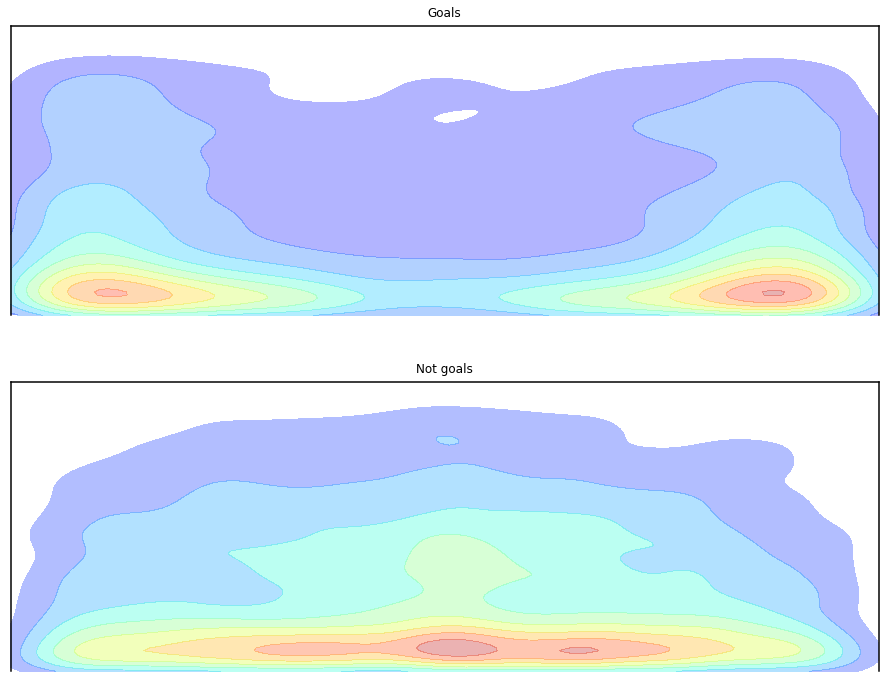

In [28]:
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=1)

# plot goalmouths
ax[0] = plot_goalmouth(ax[0])
ax[1] = plot_goalmouth(ax[1])

# These two lines convert the Opta y-z coordinates
# to our own x-y coordinates in the ranges [0,24]
# and [0,8], respectively
x = (df[df['goal']==1]['y']-45.2)/(54.8-45.2)*24
y = df[df['goal']==1]['z']/38*8
# plot goals
sns.kdeplot(x, y, ax=ax[0], shade=True, shade_lowest=False, cmap='jet', alpha=0.3, clip=[[0,24],[0,8]])
ax[0].set_xlim([-0.1, 24.1])
ax[0].set_ylim([-0.1, 8.1])
ax[0].set_title('Goals')

# plot not goals
x = (df[df['goal']==0]['y']-45.2)/(54.8-45.2)*24
y = df[df['goal']==0]['z']/38*8
sns.kdeplot(x, y, ax=ax[1], shade=True, shade_lowest=False, cmap='jet', alpha=0.3, clip=[[0,24],[0,8]])
ax[1].set_xlim([-0.1, 24.1])
ax[1].set_ylim([-0.1, 8.1])
ax[1].set_title('Not goals')

plt.show()

These heat maps just show us where the most goals and not goals are landing on the face of the goal. They are not showing us the probability of a shot becoming a goal given it's locaiton on the face of the goal.

# Probability based on goalmouth location

In [29]:
# Normalize the Opta goalmouth y-z coordinates to our 
# own x-y coordinates in the ranges [0,24] and [0,8]
x = (df['y']-45.2)/(54.8-45.2)*24
y = df['z']/38*8
        
# Create a grid to plot a smooth probability surface on
stepsize = 0.25
xx, yy = np.meshgrid(np.arange(0,24,stepsize), np.arange(0,8,stepsize))

# Get the probability of scoring at each grid location
zz = list()
for rows, cols in zip(xx,yy):
    for row, col in zip(rows,cols):
        # find shots in the current square
        horizontal = np.logical_and(x>=row, x<(row+stepsize))
        vertical = np.logical_and(y>=col, y<(col+stepsize))
        in_square = df.loc[np.where(np.logical_and(horizontal, vertical))[0], :]
        # determine if shots were goals or not
        goals = in_square[in_square['goal']==1].shape[0]
        not_goals = in_square[in_square['goal']==0].shape[0]
        try:
            # add the probability to the list
            zz.append(goals / (goals+not_goals))
        except:
            # some locations won't have any shots in them, handle divide by zero
            zz.append(0)
# make the probabilities the right shape
zz = np.array(zz).reshape(xx.shape)
# Smooth out the probabilites
zz = gaussian_filter(zz, 3)

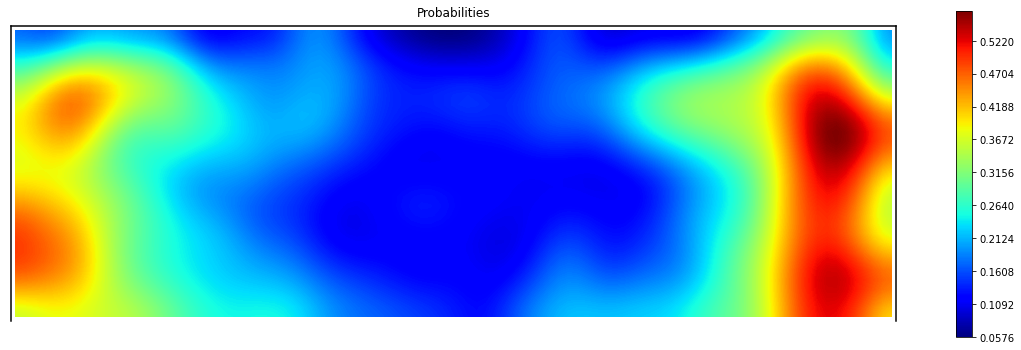

In [38]:
# plot the probabilities
fig, ax = plt.subplots(figsize=[20,6])
ax = plot_goalmouth(ax)
cf = ax.contourf(
    xx+stepsize/2, yy+stepsize/2, zz,
    cmap='jet', alpha=1, levels=1000)
ax.set_xlim([-0.1, 24.1])
ax.set_ylim([-0.1, 8.1])
ax.set_title('Probabilities')
plt.colorbar(cf)
plt.show()